<a href="https://colab.research.google.com/github/the-bucketless/iihf/blob/main/iihf_shot_charts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IIHF Shot Charts

This notebook extracts the data from the shot charts in the PDFs that the IIHF provides.  

The coordinates of shots as well as their type and the jersey number of the player who took the shot can be found from the drawings on the PDF (as opposed to the images or text).  

The text can't be read by the PDF package, so the team names and goalie numbers are found using optical character recognition (OCR).  

Two CSV files can be downloaded for each game:
- The shot locations on the rink.
- The goal locations in the net.

When the goal is on an empty net, the goalie number is set to -1.

# Installs and Imports

I've chosen to use an earlier version of pytesseract for the sole purpose of avoiding having to restart the runtime after running this cell.  The newest version requires an update to PIL, which isn't an issue, but this way 'Run all' is an option.

In [1]:
!pip install hockey-rink
!pip install pymupdf
!pip install pytesseract==0.2.6
!sudo apt install tesseract-ocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for hockey-rink: filename=hockey_rink-0.1.8-py3-none-any.whl size=35212 sha256=67b17fafe60093db86bbff9ddccbd9347071b304368371341ae696447b2272f8
  Stored in directory: /root/.cache/pip/wheels/4e/f3/da/80d1c42242249812d2f286a65cd0dfe413d2775d61130db832
Successfully built hockey-rink
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.8 MB 15.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 169 kB 14.0 MB/s 
  Created wheel for pytesseract: filename=pytesseract-0.2.6-py2.py3-none-any.whl size=165667 sha256=44bad340da24e2bfa3e6e06379edbfc4637faf55807693989ce22e30ccff185c
  Stored in directory: /root/.cache/pip/wheels/ff/32/6d/0c7083e5ffd6d73e2ef722ba7ab383f71d31497161c3c9a7e2
Successfully buil

In [2]:
from collections import namedtuple
import fitz
from functools import partial
from google.colab import files
from hockey_rink import Rink
from io import BytesIO
from itertools import permutations, product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import pytesseract
import requests

# Some Necessary Assumptions

As far as I've seen, all the PDFs use the same sized rink regardless of where the game was played. These are the standard international rink dimensions. I've left them as parameters in case updates are necessary.

In [3]:
rink_length = 197    #@param {type: "number"}
rink_width = 98.4    #@param {type: "number"}

If either of the following assumptions don't hold, changes will be needed: 
- The images of nets used in the PDFs have a width of 543. I've used this to determine where goals need to be pulled from.
- Rink images are determined based on which image on the page is widest.

The net width can updated by changing NET_IMAGE_WIDTH. The rink image will require diving in to some code.

In [4]:
# need to increase size of pdf for ocr to work well
ZOOM = 5

# hockey nets are 6' x 4'
NET_HEIGHT = 4
NET_WIDTH = 6

# net images in the pdfs have width 543
NET_IMAGE_WIDTH = 543

# Shots from Drawings

The characters used to denote shots on the rink and in the nets are made using draw commands. These consist of lines (l) and curves (c). The characters used for the different shot types are:
- Goal: o
- Shot (SSG): +
- Miss (SPG): -
- Block (SSP): < or > 

Fortunately, the combinations of these characters and the numbers that either precede or follow them create unique sequences of 'l's and 'c's. As a result, we can use these as keys in a dictionary to find the shot types and numbers.

In [5]:
shot_types = {
    "Goal": "ccccccccccccccccc",
    "Shot": "llllllllllll",
    "Block": "lllllll",
    "Miss": "llll",
}

numbers = {
    1: "llcclccll",
    2: "llccccccccclcccccccccl",
    3: "lccccccclccccccclccccccccccccc",
    4: "llllllllllllll",
    5: "lccccccccllllllccccccc",
    6: "lccccccccccccccccccccccccccc",
    7: "lllccclcccl",
    8: "ccccccccccccccccccccccccccccccccc",
    9: "lccccccccccccccccccccccccccccc",
    0: "cccccccccccccccccccc",
}

# separate dicts based on whether the shot is at the left net or the right net
# the order of numbers and shot types are reversed depending on where the net is
shot_items = {"left": {}, "right": {}}
for shot_type, number in product(shot_types.keys(), [str(i) for i in range(100)]):
    shot_type_str = shot_types[shot_type]
    number_str = "".join(numbers[int(n)] for n in number)
    
    shot_items["left"][shot_type_str + number_str] = (shot_type, int(number))
    shot_items["right"][number_str + shot_type_str] = (shot_type, int(number))

In [6]:
def shot_from_drawing(drawing, direction):
    """ Use the lines and curves of a drawing to determine the shot type and jersey number. """
    item_str = "".join(x[0] for x in drawing["items"])
    return shot_items[direction][item_str]

# Some Necessary Functions

Coordinates are determined based on:
- x: the coordinate of the drawing that is closest to the net the shot was directed at.
- y: the center of the bounding box of the drawing.

compute_coord provides the coordinates for the rink and allows for the partial function compute_net_coord for coordinates from the nets.

In [7]:
def compute_coord(
    drawing, bounding_rect, direction, x_offsets=(1, 1), y_offsets=(1, 1), 
    feature_length=rink_length, feature_width=rink_width,
):
    """ 
    Convert coordinates from a drawing to a rink or net coordinate.

    Args:
        drawing: dict
            One of the values returned from calling get_drawings on a page of a PDF.
        
        bounding_rect: Rect
            Bounding box for the relevant image.

        direction: string
            Which direction the shot is going ("left" or "right").
        
        x_offsets: tuple
        y_offsets: tuple
            How many pixels included in the image are not a part of the rink/net.
            eg) The boards in the rink image occupy 1 pixel.

        feature_length: number
        feature_width: number
            Actual size of a rink/net.

    Returns:
        numpy array
    """

    x_index = 0 if direction == "left" else 2

    # need to subtract bounding rect coordinates to force upper left corner to (0, 0)
    x = drawing["rect"][x_index] - bounding_rect[0]
    y = (drawing["rect"][3] + drawing["rect"][1]) / 2 - bounding_rect[1]

    # can't use width/height values from object because they aren't the
    # size shown on the pdf
    bounding_width = bounding_rect[2] - bounding_rect[0] - np.sum(x_offsets)
    bounding_height = bounding_rect[3] - bounding_rect[1] - np.sum(y_offsets)

    # convert from image to actual coordinate
    coord = (
        np.array([x - x_offsets[0], y - y_offsets[0]])
        / [bounding_width, bounding_height]
        * [feature_length, feature_width]
    )

    # flip y to go from image coordinates (top left origin) to 
    # plot coordinates (bottom left origin)
    coord[1] = feature_width - coord[1]

    return coord


compute_net_coord = partial(
    compute_coord, 
    x_offsets=(5, 6),    # extra pixel to post on the right side
    y_offsets=(3, 4),    # extra pixel to bottom of net
    feature_length=NET_WIDTH,
    feature_width=NET_HEIGHT,
)

In [8]:
def get_shots(drawings, bounding_rect, is_goal=False):
    """
    Retrieve a list of shot data from all the drawings on the page.

    Used for both shots on the rink and goals on the nets.

    Values in the list are tuples of:
        - direction of the shot ("left" or "right")
        - coordinate of the shot (as a numpy array)
        - shot type ("Goal", "Shot", "Miss", "Block")
        - jersey number of the player who took the shot
    """

    coord_func = compute_net_coord if is_goal else compute_coord

    shots = []
    for drawing in drawings:
        # red shots (1, 0, 0) are directed at the right net, blue (0, 0, 1) at the left
        # need to take the x-coordinate closest to the net the shot was directed at
        # goals on the nets are always listed to the left
        direction = "left" if drawing["fill"] == (0, 0, 1) or is_goal else "right"

        if bounding_rect.contains(drawing["rect"]):
            coord = coord_func(drawing, bounding_rect, direction)

            shot_type, jersey_number = shot_from_drawing(drawing, direction)

            shots.append((direction, coord, shot_type, jersey_number))

    return shots

In [9]:
def page_to_pil(page, zoom=ZOOM, clip=None):
    """ Convert page of PDF to PIL image. """
    
    pix = page.get_pixmap(matrix=fitz.Matrix(zoom, zoom), clip=clip)
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    return img

Teams are found by OCR on the sections of the PDF that lists the goalie numbers.  
GK {#} of {TEAM}

In [10]:
def goalie_team_ocr(page, net_rect):
    # ensure there's some white space around characters for OCR
    x1 = net_rect[0] - 2
    x2 = net_rect[2] + 2
    y1 = net_rect[-1]
    y2 = y1 + 15
    
    # don't need to run OCR on the whole page, only the section
    # where goalies appear
    # if this works, goalie will be "GK {#} of {TEAM}"
    clip = [x1, y1, x2, y2]
    img = page_to_pil(page, clip=clip)
    goalie = str(((pytesseract.image_to_string(img)))).strip()

    # use jersey number of -1 to denote empty net goals
    if goalie == "ENG":
        return -1, None

    goalie = goalie.replace("0f", "of").replace("of", " of ")
    goalie_details = [x for x in goalie.split(" ") if x != ""]
    
    try:
        jersey_number = goalie_details[1]
        team = goalie_details[3]

        jersey_number = "".join(x for x in jersey_number if x.isdigit())

        try:
            jersey_number = int(jersey_number)
        except ValueError:
            jersey_number = -1

        return jersey_number, team

    except IndexError:
        print(
            f"Not enough details found for goalie clipped from {clip}. "
            f"OCR found '{goalie}'. To retrieve the goalie number and team, "
            "the string is expected to be of the form GK # of TEAM."
        )
        
        return None, None

# PDF to CSV

Everything above this section only needs to be run once. If you want to check out multiple games, update the parameters below and run the cells that follow.

In [11]:
url = "https://www.iihf.com/pdf/164/ihw164a03_77a_3_0"    #@param {type: "string"}

In [12]:
shots_filename = ""    #@param {type: "string"}
goals_filename = ""    #@param {type: "string"}

In [13]:
url_filename = url[url.rfind("/") + 1:]
shots_filename = shots_filename or f"{url_filename}_shots.csv"
goals_filename = goals_filename or f"{url_filename}_goals.csv"

response = requests.get(url)
data = BytesIO(response.content)

pdf = fitz.open(stream=data)

All the work is done here. I could've avoided looping through the PDF's drawings multiple times with the function calls, but this way felt easier to read and there aren't enough drawings for it to be any kind of a bottleneck.

In [42]:
Goal = namedtuple("Goal", ["Period", "Team", "Shooter", "Opponent", "Goalie", "X", "Y"])
Shot = namedtuple("Shot", ["Period", "Team", "Player", "Type", "X", "Y"])

goals = []
shots = []

# goalies and teams stored for use in visualization
goalies = {}
teams = {}

for page_no, page in enumerate(pdf):
    period = page_no + 1

    drawings = page.get_drawings()
    page_width = page.mediabox_size[0]

    goalies[period] = {"left": [], "right": []}
    teams[period] = {"left": None, "right": None}

    nets = {"left": [], "right": []}

    page_image_info = page.get_image_info()

    for image_info in page_image_info:
        # look below net images for goalie numbers and team names
        if image_info["width"] == NET_IMAGE_WIDTH:
            # add padding to get numbers that go outside of net
            net_rect = fitz.Rect(image_info["bbox"])
            # net_rect = fitz.Rect(image_info["bbox"]) + [-5, 0, 5, 0]
            direction = "left" if net_rect[0] < page_width / 2 else "right"
            shooting_direction = "left" if direction == "right" else "right"

            jersey_number, team = goalie_team_ocr(page, net_rect)

            nets[direction].append((jersey_number, net_rect))
            # avoid replacing team in case of empty net
            if teams[period][shooting_direction] is None:
                teams[period][shooting_direction] = team
            goalies[period][direction].append(jersey_number)

    # wait until both teams are found to look for goals and shots

    # goals
    # look inside net images for goal drawings
    for direction, opponent_direction in permutations(["left", "right"]):
        team = teams[period][direction]
        opponent = teams[period][opponent_direction]

        for goalie_number, net_rect in nets[direction]:
            for _, goal_coord, _, shooter_number in get_shots(drawings, net_rect, True):
                goals.append(Goal(period, team, shooter_number, opponent, goalie_number, *goal_coord))

    # shots
    # assume that the widest image is the rink
    rink_image_index = np.argmax([x["width"] for x in page_image_info])
    rink_rect = fitz.Rect(page_image_info[rink_image_index]["bbox"])

    # look inside rink image for shot drawings
    for direction, coord, shot_type, jersey_number in get_shots(drawings, rink_rect):
        # convert to NHL style coordinates
        x = coord[0] - rink_length / 2
        y = coord[1] - rink_width / 2

        # use direction as a fallback if team name isn't found
        team = teams.get(period, {}).get(direction, None)
        if team is None:
            team = direction
            
        shot = Shot(period, team, jersey_number, shot_type, x, y)
        shots.append(shot)

I tried to set up the shots CSV so it would with [An Nguyen](https://twitter.com/nguyenank_)'s [shot plotter app](https://shot-plotter.netlify.app/).  However, the coordinates are in feet, not meters as is required for the international rink on the app. The CSV will display on the NHL rink, though some shots will get cut off.  

In [43]:
shots_df = pd.DataFrame(shots)
shots_df.to_csv(shots_filename, index=False)

goals_df = pd.DataFrame(goals)
goals_df.to_csv(goals_filename, index=False)

Download the files.  If the dialog box doesn't show up, you can find them in the Files section to the left of the screen.

In [32]:
files.download(shots_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
files.download(goals_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Visualization

I've tried to create a reasonable approximation of the important details that come from the PDF. The plot can be compared to the image of the PDF to ensure that things ran properly.

In [44]:
light_blue = (0.14, 0.63, 0.85)
crease_blue = (0.87, 0.91, 0.97)

rink = Rink(
    boards={"length": 197, "width": 98.4, "thickness": 0.5}, 
    nzone={"length": 47}, 
    goal_line={"x": 85.48},
    faceoff_circle={"x": 63.48},
    trapezoid={"visible": False},
    net={"visible": False},
    blue_line={"color": light_blue},
    center_dot={"color": light_blue},
    center_circle={"color": light_blue},
    crease={"color": crease_blue},
)

shot_types = {
    "Goal": "o",
    "Shot": "+",
    "Miss": "-",
    "Block": "<",
}

ordinals = {1: "st", 2: "nd", 3: "rd"}

Only viewing one page at a time.  

Change this and re-run the cells following it to view other pages.

In [45]:
period =     1#@param {type: "number"}

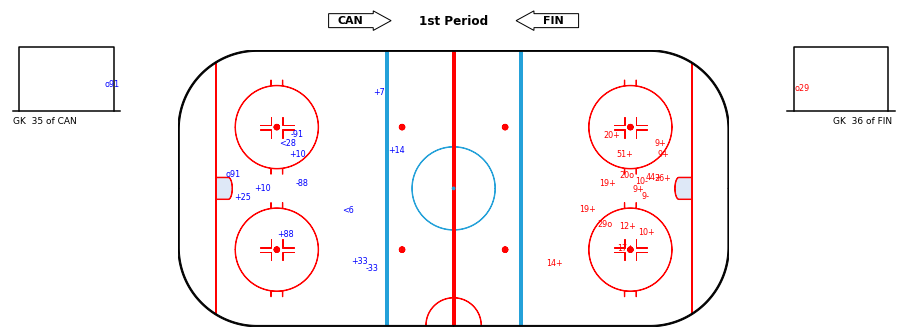

In [46]:
fig = plt.figure(figsize=(16, 6))

gs = fig.add_gridspec(
    6, 3, 
    height_ratios=[0.1, 0.25, 0.1, 0.25, 0.1, 0.2],
    width_ratios=[0.15, 0.7, 0.15], 
)

title_ax = fig.add_subplot(gs[0, :])
rink_ax = fig.add_subplot(gs[1:, 1])
net_axs = {
    "left": [
        fig.add_subplot(gs[1, 0]),
        fig.add_subplot(gs[3, 0]),
    ],
    "right": [
        fig.add_subplot(gs[1, 2]),
        fig.add_subplot(gs[3, 2]),
    ],
}

rink.draw(ax=rink_ax)

plot_shots = shots_df.loc[shots_df.Period == period]
left_team = teams[period]["left"]
right_team = teams[period]["right"]

# annotate the shots on the rink
for row in plot_shots.itertuples():
    txt = str(row.Player)
    shot_type = shot_types[row.Type]

    if row.Team == left_team:
        color = "blue"
        txt = shot_type + txt

        horizontalalignment = "left"
    else:
        color = "red"

        if shot_type == "<":
            shot_type = ">"
        txt = txt + shot_type

        horizontalalignment = "right"

    rink_ax.annotate(txt, (row.X, row.Y), 
                     c=color, fontsize=8, zorder=101, 
                     ha=horizontalalignment, va="center",
    )

# period number at top center
title_ax.text(
    0.5, 0.5, 
    f"{period}{ordinals.get(period, 'th')} Period", 
    horizontalalignment="center", verticalalignment="center", 
    fontsize=12, fontweight="bold"
)

# arrows indicating the direction teams are playing
arrow_params = {"head_width": 0.7, "head_length": 0.02, "width": 0.5, "facecolor": "white"}
title_ax.arrow(0.36, 0.5, 0.05, 0, **arrow_params)
title_ax.arrow(0.64, 0.5, -0.05, 0, **arrow_params)
title_ax.text(0.37, 0.41, right_team, fontsize=11, fontweight="bold")
title_ax.text(0.6, 0.41, left_team, fontsize=11, fontweight="bold")
title_ax.axis("off")

# the nets on either side
for direction, goalie_x, team, color in zip(
    ("left", "right"), (-0.4, 2.5), (right_team, left_team), ("blue", "red")
):
    for i in range(2):
        net_axs[direction][i].axis("off")

    for i, goalie in enumerate(goalies[period][direction]):
        ax = net_axs[direction][i]
        
        ax.plot([0, 0, 6, 6], [0, 4, 4, 0], color="black")
        ax.plot([-0.4, 6.4], [0, 0], color="black")

        if goalie == -1:
            empty_net_x = 5 if goalie_x == 2.5 else goalie_x
            ax.text(empty_net_x, -0.8, "ENG", fontsize=9)
        else:
            ax.text(goalie_x, -0.8, f"GK  {goalie} of {team}", fontsize=9)

        plot_goals = goals_df.loc[
            (goals_df.Period == period) 
            & (goals_df.Opponent == team)
            & (goals_df.Goalie == goalie)
        ]
        for row in plot_goals.itertuples():
            txt = f"o{row.Shooter}"
            
            ax.annotate(txt, (row.X, row.Y), 
                        c=color, fontsize=8, zorder=101,
                        ha="left", va="center",
            )


fig.set_facecolor("white")

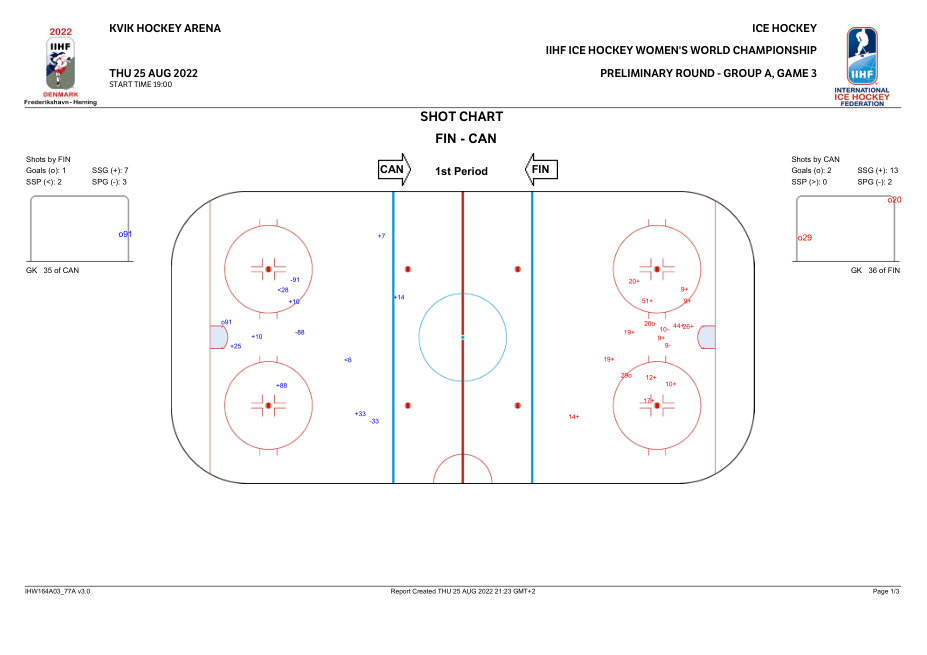

In [47]:
page = pdf.load_page(period - 1)
page_to_pil(page, 1.1)